In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [11]:
len(words)

32033

In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
block_size =  3 #context length. How many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% samples
Xdev, Ydev = build_dataset(words[n1:n2]) #10% samples
Xte, Yte = build_dataset(words[n2:]) #10% samples

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [31]:
n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

      0/ 200000:27.5998
  10000/ 200000:2.8733
  20000/ 200000:2.3622
  30000/ 200000:2.2829
  40000/ 200000:2.4869
  50000/ 200000:2.1301
  60000/ 200000:2.0658
  70000/ 200000:2.2376
  80000/ 200000:1.9142
  90000/ 200000:2.0505
 100000/ 200000:2.2172
 110000/ 200000:2.0449
 120000/ 200000:2.1224
 130000/ 200000:2.4018
 140000/ 200000:2.0397
 150000/ 200000:2.2257
 160000/ 200000:2.0104
 170000/ 200000:2.1132
 180000/ 200000:1.9078
 190000/ 200000:2.0661


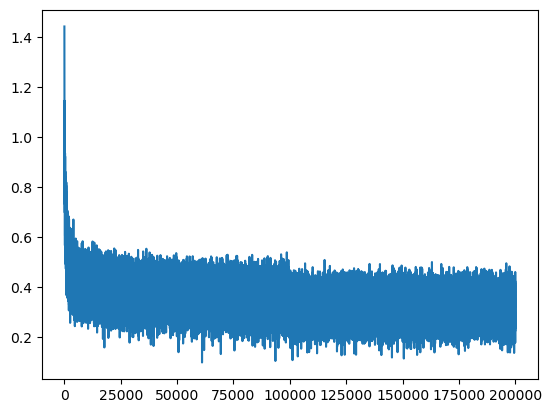

In [33]:
plt.plot(lossi)

In [36]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1270546913146973
val 2.16108775138855


In [38]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carpah.
aab.
havi.
kimri.
rehtyn.
kanden.
jazhitna.
merynci.
aqui.
ner.
kiah.
maiivon.
legg.
dham.
jore.
quint.
suline.
liveni.
waje.
madiarynix.
